In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing

Quiero asociar a cada fecha el numero de usuarios totales que hablaron de bitcoin ese dia. Para esto necesito las columnas de fecha y de username. Agrupando por fecha, contare el numero de usuarios distintos de fomra de obtener un numero que despues pueda agregar al otro dataset.

Partimos con la limpieza de los datos. Para esto eliminamos las columnas que no necesitamos, que serian todas menos la de username y la de la fecha. Y la de la fecha la discretizaremos a dias, descartando en que hora, minuto y segundo fue hecho el tweet. Ademas usaremos los tweets desde el 2016-01-01.

In [ ]:
# Reading the dataset with no columns titles and with latin encoding 
df_raw = pd.read_csv('/Users/josevera/Desktop/mineria de datos/proyecto/tweets.csv', delimiter=";", skiprows=0, lineterminator="\n" )
df_raw.columns = ["id", "user", "fullname", "url", "timestamp", "replies","likes","retweets","text"] #le pongo el nombre a las columnas
df = df_raw[['id','timestamp']] #extraemos solo las que nos importan
df['date'] = pd.to_datetime(df['timestamp'],format= '%Y-%m-%d').dt.date  #creamos la columna date son solo año-mes-dia
df = df.sort_values(by='date')     #ordenamos por fecha
df=df[['id','date']]#eliminamos la columna timestamp que no necesitamos             
df['indice'] = df['date'] #duplicamos la columna date
df = df.set_index('indice')    #definimos el index como la fecha
startdate = pd.to_datetime("2015-12-31").date() #definimos fecha de inicio
df = df.loc[startdate:] #aplicamos la fecha de inicio al dataset
result = df.groupby(by='date', as_index=False).agg({'id': pd.Series.nunique}) #por ultimo, agrupamos por fecha en result, teniendo en id el numero de personas que twittearon 
result = result.rename(columns={"id":"Tweets_yesterday"})

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Queremos basar nuestro modelo predictivo en los tweets del dia anterior, por lo que necesitaremos partir desde un dia antes del 1 de enero del 2016 y sumarles un dia, de esta manera podemos buscar si existe alguna influencia en el numero de tweets del dia anterior con la fluctuacion de precios (sea en aumento o disminucion del precio). Procedemos entonces a sumar un dia a la columna 'date':

In [ ]:
result['Fecha'] = result['date'] + pd.Timedelta('1 days')
result.head()

,date,Tweets_yesterday,Fecha
0,2015-12-31,579.0,2016-01-01
1,2016-01-01,700.0,2016-01-02
2,2016-01-02,657.0,2016-01-03
3,2016-01-03,474.0,2016-01-04
4,2016-01-04,525.0,2016-01-05


Ya habiendo terminado con la preparacion de los datos de los tweets estan preparados para un join, procedemos a los datos del bitcoin. Los datos de los tweets son desde el 1 de enero de 2016 hasta el 24 de noviembre de 2019.

Si nos vamos a la realidad, es casi imposible determinar un valor exacto para el bitcoin. Por esto buscaremos algo mas sencillo pero igual de util. Nuestro clasificador buscara predecir si el valor con el que cerrara el bitcoin ese dia (close) sera mayor o menor que el valor con el que abrio (Open). Esto nos permite determinar si vale la pena invertir al inicio de ese dia o no.

Para predecir esto necesitaremos algunos datos del dia (como el marketcap, el volumen y el valor en el que abre el mercado). Pero tambien usaremos valores del dia anterior, como el High y el Low (ya que esto permite incluir dentro del clasificador que tan volatil esta el mercado y en que direccion se estuvo moviendo el dia anterior), el Close y el numero de tweets del dia anterior que lo usaremos como medidor de popularidad. Entonces pasemos a crear 2 datasets, uno que este al dia y el otro desfasado un dia, luego los uniremos entre ellos y con el dataset de tweets para asi tener nuestros datos finales para proceder al clasificador.

Por ultimo, cabe mencionar que debido a que solo usaremos el bitcoin, las columnas Name y Symbol serian redundantes y no las usaremos para facilitar el manejo de los datos.

In [ ]:
df = pd.read_csv('/Users/josevera/Desktop/mineria de datos/proyecto/coin_Bitcoin.csv', delimiter=",", skiprows=0, lineterminator="\n" )
df.columns = ["indice","Name", "Symbol", "Date", "High", "Low", "Open","Close","Volume","Marketcap"]
df['date'] = pd.to_datetime(df['Date'],format= '%Y-%m-%d').dt.date  #creamos la columna date son solo año-mes-dia
df = df.sort_values(by='date') #ordenamos por fecha
df=df[["date", "High", "Low", "Open","Close","Volume","Marketcap"]] #eliminamos las columnas que no necesitamos
df1=df[["date","High","Low", "Close", "Open"]] #este sera el dataset que estara desfasado un dia
df2=df[["date", "Open", "Close", "Volume", "Marketcap"]] #este sera el dataset que estara al dia

#desfasamos un dia el dataframe1 y lo restringimos a las fechas:

df1 = df1.rename(columns={"Close":"Close_yesterday","High":"Variation_yesterday","Low":"Low_yesterday", "Open": "Subio_ayer"})
df1['Fecha'] = df1['date'] + pd.Timedelta('1 days') #al sumar un dia, a cada columna de valores queda asignado la fecha del dia siguiente.
df1 = df1.sort_values(by='Fecha')   
df1 = df1.set_index('date') 
mask = (df1['Fecha'] > pd.to_datetime("2015-12-31").date()) & (df1['Fecha'] <= pd.to_datetime("2019-11-24").date()) #lo restingimos al periodo de tiempo de los tweets
df1 = df1.loc[mask]
df1["Subio_ayer"]= df1["Subio_ayer"]<df1["Close_yesterday"]
df1["Variation_yesterday"]= df1["Variation_yesterday"]-df1["Low_yesterday"]
df1 = df1[["Subio_ayer","Variation_yesterday","Fecha"]]


df1.head()

,Subio_ayer,Variation_yesterday,Fecha
date,,,
2015-12-31,True,14.186005,2016-01-01
2016-01-01,True,8.730988,2016-01-02
2016-01-02,False,4.192017,2016-01-03
2016-01-03,False,9.037018,2016-01-04
2016-01-04,True,5.432983,2016-01-05


In [ ]:
#Ahora vamos con el otro dataset, solo debemos restringirlo al periodo de fechas con las que trabajaremos
df2['Fecha'] = df2['date']
df2 = df2.sort_values(by='Fecha')   
df2 = df2.set_index('date') 
mask = (df2['Fecha'] > pd.to_datetime("2015-12-31").date()) & (df2['Fecha'] <= pd.to_datetime("2019-11-24").date()) #lo restingimos al periodo de tiempo de los tweets
df2 = df2.loc[mask]

#Pasamos ahora a crear la columna que queremos predecir, que seria el booleano si el close del dia sera mayor que el open:

df2= df2.rename(columns={"Close":"Higher_close_value?"})
df2["Higher_close_value?"]= df2["Open"]<df2["Higher_close_value?"]

df2.tail()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,Higher_close_value?,Volume,Marketcap,Fecha
date,,,,,
2019-11-20,8203.613180,False,2.076430e+10,1.449627e+11,2019-11-20
2019-11-21,8023.644687,False,2.251424e+10,1.380319e+11,2019-11-21
2019-11-22,7643.569425,False,3.424232e+10,1.317918e+11,2019-11-22
2019-11-23,7296.164425,True,2.100892e+10,1.336362e+11,2019-11-23
2019-11-24,7398.633906,False,3.043352e+10,1.273274e+11,2019-11-24


Ahora teniendo todos los dataset listos, podemos pasar a unirlos usando los valores de la columna Fecha que es la que tienen en comun todas las tablas. Para esto usaremos la funcion merge entre la df1 y df2, y luego con result para obtener nuestro dataset final.

In [ ]:
merged_bitcoin = pd.merge(left=df1,right=df2, left_on='Fecha', right_on='Fecha')
final_result = pd.merge(left=merged_bitcoin,right=result, left_on='Fecha', right_on='Fecha')
final_result.head()

,Subio_ayer,Variation_yesterday,Fecha,Open,Higher_close_value?,Volume,Marketcap,Tweets_yesterday
0,True,14.186005,2016-01-01,430.721008,True,36278900.0,6.529300e+09,579.0
1,True,8.730988,2016-01-02,434.622009,False,30096600.0,6.517390e+09,700.0
2,False,4.192017,2016-01-03,433.578003,False,39633800.0,6.467430e+09,657.0
3,False,9.037018,2016-01-04,430.061005,True,38477500.0,6.515713e+09,474.0
4,True,5.432983,2016-01-05,433.069000,False,34522600.0,6.500393e+09,525.0


Teniendo ya esto, podemos entonces pasar a la seccion del clasificador.

Para el clasificador, usaremos varios metodos y luego analizaremos sus resultados para determinar cual seria el mejor en este caso.

Empezamos por un clasificador de arbol de decision:


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  # support vector machine classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score


Btc= final_result

clf = DecisionTreeClassifier()

X = Btc[["Subio_ayer","Variation_yesterday","Open","Volume","Marketcap","Tweets_yesterday"]]     ## datos, caracteristicas o features 
y = Btc["Higher_close_value?"]    ## clase para cada instancia anterior

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=37,
                                                    stratify=y)

#Primero fiteamos el clasificador
clf.fit(X_train,y_train)
#Predecimos
y_predict=clf.predict(X_test)
#Creamos el reporte
print("Accuracy:", accuracy_score(y_test, y_predict))
print(classification_report(y_test,y_predict))


Accuracy: 0.6404255319148936
              precision    recall  f1-score   support

       False       0.59      0.61      0.60       209
        True       0.68      0.67      0.67       261

    accuracy                           0.64       470
   macro avg       0.64      0.64      0.64       470
weighted avg       0.64      0.64      0.64       470



Ya vemos que tenemos nuestro primer clasificador, podemos proceder a probar los demas clasificadores y compararlos para determinar si alguno seria valido para nuestro objetivo.


In [ ]:
def run_classifier(clf, X, y, num_tests=100):
    metrics = {'f1-score': [], 'precision': [], 'recall': []}
    
    for _ in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=37,
                                                    stratify=y)
        clf.fit(X_train,y_train)
        predictions=clf.predict(X_test)
        metrics['y_pred'] = predictions
        metrics['f1-score'].append(f1_score(y_test, predictions)) 
        metrics['recall'].append(recall_score(y_test, predictions))
        metrics['precision'].append(precision_score(y_test, predictions))
    
    return metrics

c0 = ("Base Dummy", DummyClassifier(strategy='stratified'))
c1 = ("Decision Tree", DecisionTreeClassifier(max_depth=5))
c2 = ("Gaussian Naive Bayes", GaussianNB())
c3 = ("KNN", KNeighborsClassifier(n_neighbors=10))
c4 = ("Support Vector Machines", SVC())

classifiers = [c0, c1, c2, c3, c4]

results = {}
for name, clf in classifiers:
    metrics = run_classifier(clf, X, y)   # hay que implementarla en el bloque anterior.
    results[name] = metrics
    print("----------------")
    print("Resultados para clasificador: ", name) 
    print("Precision promedio:", np.array(metrics['precision']).mean())
    print("Recall promedio:", np.array(metrics['recall']).mean())
    print("F1-score promedio:", np.array(metrics['f1-score']).mean())
    print("----------------\n\n")  

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.5573387409723601
Recall promedio: 0.5583193277310923
F1-score promedio: 0.5576250043823202
----------------


----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.5731109303423709
Recall promedio: 0.8253781512605042
F1-score promedio: 0.6764906589716324
----------------


----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.5502645502645503
Recall promedio: 0.8739495798319329
F1-score promedio: 0.6753246753246752
----------------


----------------
Resultados para clasificador:  KNN
Precision promedio: 0.5739130434782611
Recall promedio: 0.5546218487394956
F1-score promedio: 0.564102564102564
----------------


----------------
Resultados para clasificador:  Support Vector Machines
Precision promedio: 0.55607476635514
Recall promedio: 1.0
F1-score promedio: 0.7147147147147147
----------------




# MAS QUE UN SENTIMIENTO UNA EMOCION; COLO COLO LO MAS GRANDE P1

In [ ]:
!gdown --id 1NTntqn7s7Nmvjvr9X69Go-EIE5Jp3c-U

Downloading...
From: https://drive.google.com/uc?id=1NTntqn7s7Nmvjvr9X69Go-EIE5Jp3c-U
To: /content/x00
100% 599M/599M [00:05<00:00, 116MB/s]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
# Langdetect
# ==============================================================================
!pip install langdetect
import langdetect
# pycld2
# ==============================================================================
# pycld3
# ==============================================================================
!pip install -U pycld3
import cld3
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 981 kB 10.1 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=315086b6fff9af1081d415950580c615fcab28d6b5c4b2f47c8ef74f19daf6a9
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 13.6 MB 6.3 MB/s 


In [ ]:
#Tweets
df_tweets = pd.read_csv('/content/x00', delimiter=";", skiprows=0, lineterminator="\n" )


In [ ]:


df_tweets.columns = ["id", "user", "fullname", "url", "timestamp", "replies","likes","retweets","text"] #le pongo el nombre a las columnas

#Borramos ultima fila por tema del corte de la wa, para el dataset entero eliminar la siguiente fila
df_tweets.drop(df_tweets.tail(1).index,inplace=True) # drop last n rows

df_tweets_text = df_tweets[['id','text','likes','timestamp']] #extraemos solo las que nos importan
df_tweets_text ['date'] = pd.to_datetime(df_tweets_text ['timestamp'],format= '%Y-%m-%d').dt.date  #creamos la columna date son solo año-mes-dia
df_tweets_text =df_tweets_text[['id','text','likes','date']]



In [ ]:
#caso provisorio para trabajar rapido con un pequeño conjunto de tweets
df_tweets_text#=df_tweets_text.iloc[0:100]

,id,text,likes,date
0,1132977055300300800,È appena uscito un nuovo video! LES CRYPTOMONN...,0.0,2019-05-27
1,1132977073402736640,Cardano: Digitize Currencies; EOS https://t.co...,0.0,2019-05-27
2,1132977023893139456,Another Test tweet that wasn't caught in the s...,2.0,2019-05-27
3,1132977089089556481,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,0.0,2019-05-27
4,1132977092340191232,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,0.0,2019-05-27
...,...,...,...,...
2508634,991980692148977666,03/05/2018 - 13:00\n=========================...,0.0,2018-05-03
2508635,991980690290823168,"Bitcoin - BTC\nPrice: $9,195.21\nChange in 1h:...",0.0,2018-05-03
2508636,994759368955650048,Current price of Bitcoin is $8920.00\r,0.0,2018-05-11
2508637,991980499026563073,#BTC Average: 9214.79$\n\n#Bitfinex - 9212.10$...,0.0,2018-05-03


In [ ]:
#Filtrar en inglish plis
largo=df_tweets_text.shape[0]
df_en=pd.DataFrame()
delete=[]
for x in range(largo):
  if cld3.get_language(df_tweets_text.loc[x]['text'])[0]=='en':
    continue
  else:
    delete+=[x]
df_tweets_text=df_tweets_text.drop(delete,axis=0)

In [ ]:
df_tweets_text

In [ ]:
import re
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [ ]:
#Limpieza y tokenizacion de texto tokenizacion
df_tweets_text['tokens'] = df_tweets_text['text'].apply(lambda x: limpiar_tokenizar(x))
df_tweets_text[['text', 'tokens']].head()


,text,tokens
2,Another Test tweet that wasn't caught in the s...,"[another, test, tweet, that, wasn, caught, in,..."
6,@nwoodfine We have been building on the real #...,"[nwoodfine, we, have, been, building, on, the,..."
9,"CHANGE IS COMING...GET READY!!! Boom, Another ...","[change, is, coming, get, ready, boom, another..."
10,One of the useful articles of Stefan; here is ...,"[one, of, the, useful, articles, of, stefan, h..."
11,"BTC IS STILL GOING STRONG!!\n\nThus, we are gi...","[btc, is, still, going, strong, thus, we, are,..."


In [ ]:
#Filtrado para excluir stopwords
stop_words=list(stopwords.words('english'))

#Analisis de sentimiento, Se trabaja con diccionarios sentiment lexicon
sens= pd.read_table('https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',names = ['termino', 'sentimiento'])
sent_dic = sens.set_index('termino').T.to_dict('list')

total=[]
for u in range(len(df_tweets_text)):
  priori=0
  l=df_tweets_text['tokens'].iloc[u]
  for j in l:
    if j in stop_words:
      l.remove(j)
    if j in sent_dic:
      priori+=sent_dic[j][0]
  total+=[priori]
df_sent=pd.DataFrame(total,columns=["Sentimiento"])


In [ ]:
todofinal = pd.concat([df_tweets_text.reset_index(drop=True), df_sent], axis=1)
todofinal

,id,text,likes,date,tokens,Sentimiento
0,1132977023893139456,Another Test tweet that wasn't caught in the s...,2.0,2019-05-27,"[another, test, tweet, wasn, caught, the, stre...",0
1,1132977101638897665,@nwoodfine We have been building on the real #...,0.0,2019-05-27,"[nwoodfine, have, building, the, real, bitcoin...",0
2,1132977132714561536,"CHANGE IS COMING...GET READY!!! Boom, Another ...",0.0,2019-05-27,"[change, coming, get, ready, boom, another, cb...",0
3,1132977076921933825,One of the useful articles of Stefan; here is ...,14.0,2019-05-27,"[one, useful, articles, stefan, is, the, guide...",2
4,1130878355375501313,"BTC IS STILL GOING STRONG!!\n\nThus, we are gi...",81.0,2019-05-21,"[btc, still, going, strong, thus, are, giving,...",2
...,...,...,...,...,...,...
1211633,991981234808066048,Current price of #Bitcoin is $9180.00 via Chai...,1.0,2018-05-03,"[current, price, bitcoin, via, chain, btcusd, ...",0
1211634,991980956700626944,T Shirt - Bitcoin The Future Will Be Blockchai...,0.0,2018-05-03,"[shirt, bitcoin, future, be, blockchained, cry...",0
1211635,991980920294043650,"The current price of 1 $BTC on May 3, 2018 at ...",0.0,2018-05-03,"[current, price, btc, may, am]",0
1211636,991980694036451328,"Current BTC Price: $ 9,180.00. The 24H Change ...",0.0,2018-05-03,"[current, btc, price, change, volume, and, cur...",0


In [ ]:
df = todofinal.sort_values(by='date')

In [ ]:
df.reset_index(drop=True)

NameError: ignored

No handles with labels found to put in legend.


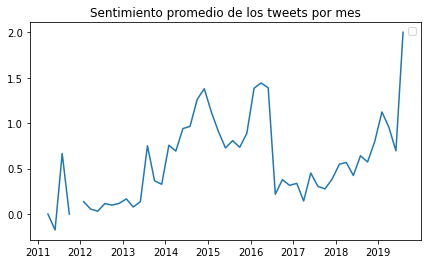

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4)) 

df["date"]=pd.to_datetime(df["date"])
df = df.set_index("date")
df = df[['Sentimiento']].resample('1M').mean()
ax.plot(df.index, df.Sentimiento)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend();

In [ ]:
#cantidad de tweets



# MAS QUE UN SENTIMIENTO UNA EMOCION; COLO COLO LO MAS GRANDE P2

In [ ]:
!gdown --id 1414xTRA1c58ONehXk-ZUkIrarFi8e7Kl
#https://drive.google.com/file/d/1414xTRA1c58ONehXk-ZUkIrarFi8e7Kl/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1414xTRA1c58ONehXk-ZUkIrarFi8e7Kl
To: /content/tweets.csv
100% 4.19G/4.19G [01:12<00:00, 58.2MB/s]


In [ ]:
#Tweets
df_tweets = pd.read_csv('/content/tweets.csv', delimiter=";", skiprows=0, lineterminator="\n" )


In [ ]:


df_tweets.columns = ["id", "user", "fullname", "url", "timestamp", "replies","likes","retweets","text"] #le pongo el nombre a las columnas

#Borramos ultima fila por tema del corte de la wa, para el dataset entero eliminar la siguiente fila
df_tweets.drop(df_tweets.tail(1).index,inplace=True) # drop last n rows

df_tweets_text = df_tweets[['id','text','likes','timestamp']] #extraemos solo las que nos importan
df_tweets_text ['date'] = pd.to_datetime(df_tweets_text ['timestamp'],format= '%Y-%m-%d').dt.date  #creamos la columna date son solo año-mes-dia
df_tweets_text =df_tweets_text[['id','text','likes','date']]



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
# Langdetect
# ==============================================================================
!pip install langdetect
import langdetect
# pycld2
# ==============================================================================
# pycld3
# ==============================================================================
!pip install -U pycld3
import cld3
import re

!gdown --id 1414xTRA1c58ONehXk-ZUkIrarFi8e7Kl
#https://drive.google.com/file/d/1414xTRA1c58ONehXk-ZUkIrarFi8e7Kl/view?usp=sharing
#Tweets
df_tweets = pd.read_csv('/content/tweets.csv', delimiter=";", skiprows=0, lineterminator="\n" )

df_tweets.columns = ["id", "user", "fullname", "url", "timestamp", "replies","likes","retweets","text"] #le pongo el nombre a las columnas

#Borramos ultima fila por tema del corte de la wa, para el dataset entero eliminar la siguiente fila
df_tweets.drop(df_tweets.tail(1).index,inplace=True) # drop last n rows

df_tweets_text = df_tweets[['id','text','likes','timestamp']] #extraemos solo las que nos importan
df_tweets_text ['date'] = pd.to_datetime(df_tweets_text ['timestamp'],format= '%Y-%m-%d').dt.date  #creamos la columna date son solo año-mes-dia
df_tweets_text =df_tweets_text[['id','text','likes','date']]


#caso provisorio para trabajar rapido con un pequeño conjunto de tweets
df_tweets_text#=df_tweets_text.iloc[0:100]
#Filtrar en inglish plis
largo=df_tweets_text.shape[0]
df_en=pd.DataFrame()
delete=[]
for x in range(largo):
  if cld3.get_language(df_tweets_text.loc[x]['text'])[0]=='zh':
    continue
  else:
    delete+=[x]
df_tweets_text=df_tweets_text.drop(delete,axis=0)
df_tweets_text

,id,text,likes,date
0,1.132977e+18,È appena uscito un nuovo video! LES CRYPTOMONN...,0,2019-05-27
1,1.132977e+18,Cardano: Digitize Currencies; EOS https://t.co...,0,2019-05-27
2,1.132977e+18,Another Test tweet that wasn't caught in the s...,2,2019-05-27
3,1.132977e+18,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,0,2019-05-27
4,1.132977e+18,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,0,2019-05-27
...,...,...,...,...
16889759,1.198266e+18,Daily profit for HODLING BTC since 2013 Data t...,0,2019-11-23
16889760,1.198262e+18,Happy #FibonacciDay \n\nA while back I created...,16,2019-11-23
16889761,1.198266e+18,Bitcoin Suisse Certificates :) https://t.co/nd...,0,2019-11-23
16889762,1.198266e+18,Register now for the early access of the Codug...,0,2019-11-23


In [ ]:
#Filtrar en inglish plis
largo=df_tweets_text.shape[0]
df_en=pd.DataFrame()
delete=[]
for x in range(largo):
  if cld3.get_language(df_tweets_text.loc[x]['text'])[0]=='zh':
    continue
  else:
    delete+=[x]
df_tweets_text=df_tweets_text.drop(delete,axis=0)
df_tweets_text

KeyboardInterrupt: ignored

In [ ]:
df_tweets_text.to_csv("tweets_inglish.csv")

In [ ]:
from google.colab import files
files.download("tweets_inglish.csv")

In [ ]:
import re
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [ ]:
#Limpieza y tokenizacion de texto tokenizacion
df_tweets_text['tokens'] = df_tweets_text['text'].apply(lambda x: limpiar_tokenizar(x))
df_tweets_text[['text', 'tokens']].head()


,text,tokens
2,Another Test tweet that wasn't caught in the s...,"[another, test, tweet, that, wasn, caught, in,..."
6,@nwoodfine We have been building on the real #...,"[nwoodfine, we, have, been, building, on, the,..."
9,"CHANGE IS COMING...GET READY!!! Boom, Another ...","[change, is, coming, get, ready, boom, another..."
10,One of the useful articles of Stefan; here is ...,"[one, of, the, useful, articles, of, stefan, h..."
11,"BTC IS STILL GOING STRONG!!\n\nThus, we are gi...","[btc, is, still, going, strong, thus, we, are,..."


In [ ]:
#Filtrado para excluir stopwords
stop_words=list(stopwords.words('english'))

#Analisis de sentimiento, Se trabaja con diccionarios sentiment lexicon
sens= pd.read_table('https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',names = ['termino', 'sentimiento'])
sent_dic = sens.set_index('termino').T.to_dict('list')

total=[]
for u in range(len(df_tweets_text)):
  priori=0
  l=df_tweets_text['tokens'].iloc[u]
  for j in l:
    if j in stop_words:
      l.remove(j)
    if j in sent_dic:
      priori+=sent_dic[j][0]
  total+=[priori]
df_sent=pd.DataFrame(total,columns=["Sentimiento"])


In [ ]:
todofinal = pd.concat([df_tweets_text.reset_index(drop=True), df_sent], axis=1)
todofinal

,id,text,likes,date,tokens,Sentimiento
0,1132977023893139456,Another Test tweet that wasn't caught in the s...,2.0,2019-05-27,"[another, test, tweet, wasn, caught, the, stre...",0
1,1132977101638897665,@nwoodfine We have been building on the real #...,0.0,2019-05-27,"[nwoodfine, have, building, the, real, bitcoin...",0
2,1132977132714561536,"CHANGE IS COMING...GET READY!!! Boom, Another ...",0.0,2019-05-27,"[change, coming, get, ready, boom, another, cb...",0
3,1132977076921933825,One of the useful articles of Stefan; here is ...,14.0,2019-05-27,"[one, useful, articles, stefan, is, the, guide...",2
4,1130878355375501313,"BTC IS STILL GOING STRONG!!\n\nThus, we are gi...",81.0,2019-05-21,"[btc, still, going, strong, thus, are, giving,...",2
...,...,...,...,...,...,...
1211633,991981234808066048,Current price of #Bitcoin is $9180.00 via Chai...,1.0,2018-05-03,"[current, price, bitcoin, via, chain, btcusd, ...",0
1211634,991980956700626944,T Shirt - Bitcoin The Future Will Be Blockchai...,0.0,2018-05-03,"[shirt, bitcoin, future, be, blockchained, cry...",0
1211635,991980920294043650,"The current price of 1 $BTC on May 3, 2018 at ...",0.0,2018-05-03,"[current, price, btc, may, am]",0
1211636,991980694036451328,"Current BTC Price: $ 9,180.00. The 24H Change ...",0.0,2018-05-03,"[current, btc, price, change, volume, and, cur...",0


In [ ]:
df = todofinal.sort_values(by='date')

In [ ]:
df.reset_index(drop=True)

,id,text,likes,date,tokens,Sentimiento
0,52163467733499904,OH about bitcoin: this is way more exciting th...,0.0,2011-03-27,"[oh, bitcoin, is, way, exciting, swatch, inter...",0
1,58381579101286400,"I can't exactly explain what the hell it is, b...",3.0,2011-04-14,"[exactly, explain, the, hell, bitcoin, is, the...",-4
2,62164245067988992,Decided since I can't by $1000 a month in bitc...,24.0,2011-04-24,"[decided, since, by, month, bitcoin, spend, mo...",0
3,67910192188239872,"@bitcoinmedia The Dollar Vigilante, the anarch...",9.0,2011-05-10,"[bitcoinmedia, dollar, vigilante, anarchist, f...",1
4,68432019155197952,If you'd invested your money in BitCoin on Jan...,1.0,2011-05-11,"[invested, money, bitcoin, jan, you, have, ret...",0
...,...,...,...,...,...,...
1211633,1134276181342248963,Yes. Good. we care law\r,0.0,2019-05-31,"[yes, good, care, law]",4
1211634,1134509893258321920,$BTC Hash rate is strong.\r,0.0,2019-05-31,"[btc, hash, rate, strong]",0
1211635,1134510475532595200,great\r,0.0,2019-05-31,[great],3
1211636,1134610938500407296,AWESOME CLOSE OF MONTH $BTC 👀\r,0.0,2019-06-01,"[awesome, close, month, btc]",4


No handles with labels found to put in legend.


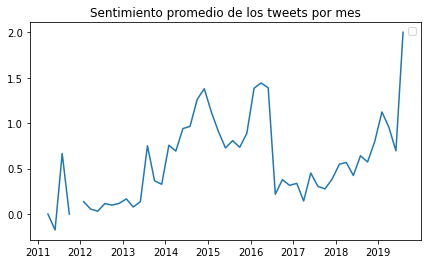

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4)) 

df["date"]=pd.to_datetime(df["date"])
df = df.set_index("date")
df = df[['Sentimiento']].resample('2M').mean()
ax.plot(df.index, df.Sentimiento)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend();